In [31]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
pd.set_option('display.max_columns', None)

In [33]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [34]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions = m_wrap.get_sub(aggregated=True)

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


delete start


In [45]:
X,y = m_wrap.get_train(aggregated=False, drop_test=False, drop_val=False) 

In [42]:
X.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [ ]:
X[X['isN']]

delete end

# Model 1

In [19]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1542232	total: 123ms	remaining: 1m 38s
1:	learn: 0.1500498	total: 256ms	remaining: 1m 42s
2:	learn: 0.1459620	total: 373ms	remaining: 1m 39s
3:	learn: 0.1422700	total: 488ms	remaining: 1m 37s
4:	learn: 0.1384624	total: 553ms	remaining: 1m 27s
5:	learn: 0.1348276	total: 665ms	remaining: 1m 27s
6:	learn: 0.1313617	total: 778ms	remaining: 1m 28s
7:	learn: 0.1279945	total: 890ms	remaining: 1m 28s
8:	learn: 0.1246471	total: 1s	remaining: 1m 28s
9:	learn: 0.1215019	total: 1.13s	remaining: 1m 29s
10:	learn: 0.1186976	total: 1.25s	remaining: 1m 29s
11:	learn: 0.1159956	total: 1.36s	remaining: 1m 29s
12:	learn: 0.1131513	total: 1.48s	remaining: 1m 29s
13:	learn: 0.1104410	total: 1.59s	remaining: 1m 29s
14:	learn: 0.1078625	total: 1.7s	remaining: 1m 28s
15:	learn: 0.1053386	total: 1.81s	remaining: 1m 28s
16:	learn: 0.1031478	total: 1.92s	remaining: 1m 28s
17:	learn: 0.1008223	total: 2.04s	remaining: 1m 28

In [20]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1543463	total: 129ms	remaining: 1m 43s
1:	learn: 0.1502025	total: 249ms	remaining: 1m 39s
2:	learn: 0.1460948	total: 369ms	remaining: 1m 38s
3:	learn: 0.1420777	total: 491ms	remaining: 1m 37s
4:	learn: 0.1382512	total: 611ms	remaining: 1m 37s
5:	learn: 0.1346663	total: 732ms	remaining: 1m 36s
6:	learn: 0.1311069	total: 854ms	remaining: 1m 36s
7:	learn: 0.1277066	total: 970ms	remaining: 1m 36s
8:	learn: 0.1244346	total: 1.09s	remaining: 1m 35s
9:	learn: 0.1214972	total: 1.21s	remaining: 1m 35s
10:	learn: 0.1184819	total: 1.33s	remaining: 1m 35s
11:	learn: 0.1156355	total: 1.45s	remaining: 1m 35s
12:	learn: 0.1128418	total: 1.57s	remaining: 1m 34s
13:	learn: 0.1102092	total: 1.68s	remaining: 1m 34s
14:	learn: 0.1075386	total: 1.8s	remaining: 1m 34s
15:	learn: 0.1052456	total: 1.92s	remaining: 1m 34s
16:	learn: 0.1028921	total: 2.04s	remaining: 1m 34s
17:	learn: 0.1005484	total: 2.16s	remaining: 1m

In [21]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1543846	total: 436ms	remaining: 5m 48s
1:	learn: 0.1502527	total: 861ms	remaining: 5m 43s
2:	learn: 0.1461764	total: 1.29s	remaining: 5m 43s
3:	learn: 0.1422029	total: 1.73s	remaining: 5m 43s
4:	learn: 0.1385706	total: 2.15s	remaining: 5m 41s
5:	learn: 0.1349877	total: 2.57s	remaining: 5m 40s
6:	learn: 0.1314021	total: 3.01s	remaining: 5m 40s
7:	learn: 0.1280528	total: 3.43s	remaining: 5m 39s
8:	learn: 0.1248570	total: 3.86s	remaining: 5m 39s
9:	learn: 0.1215955	total: 4.28s	remaining: 5m 38s
10:	learn: 0.1186264	total: 4.71s	remaining: 5m 37s
11:	learn: 0.1156714	total: 5.14s	remaining: 5m 37s
12:	learn: 0.1129363	total: 5.56s	remaining: 5m 36s
13:	learn: 0.1103998	total: 5.98s	remaining: 5m 35s
14:	learn: 0.1077262	total: 6.4s	remaining: 5m 34s
15:	learn: 0.1051750	total: 6.82s	remaining: 5m 34s
16:	learn: 0.1027915	total: 7.25s	remaining: 5m 33s
17:	learn: 0.1005908	total: 7.67s	remaining: 5m

In [22]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,NaN,0.000000,NaN,0.000000,NaN,0.489698,0.038500,-0.023706,-0.011820,-1.653340,-0.559751,0.835530,-0.013880,-0.191757,0.006791,0.003773,0.000578
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,NaN,0.000000,0.000000,0.000000,0.000000,-5.579740,-0.454217,0.001711,0.025563,-0.006602,0.228443,-7.676395,-0.007622,0.068488,-0.379527,-0.135776,-0.123534
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.042500,11.475000,0.000000,3143.002441,0.000000,4.673325,-6.618059,0.719303,2.688565,-2.534161,-0.385655,-0.769403,-8.537316,3.208530,-0.353605,4.536057,-4.163466
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,NaN,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000

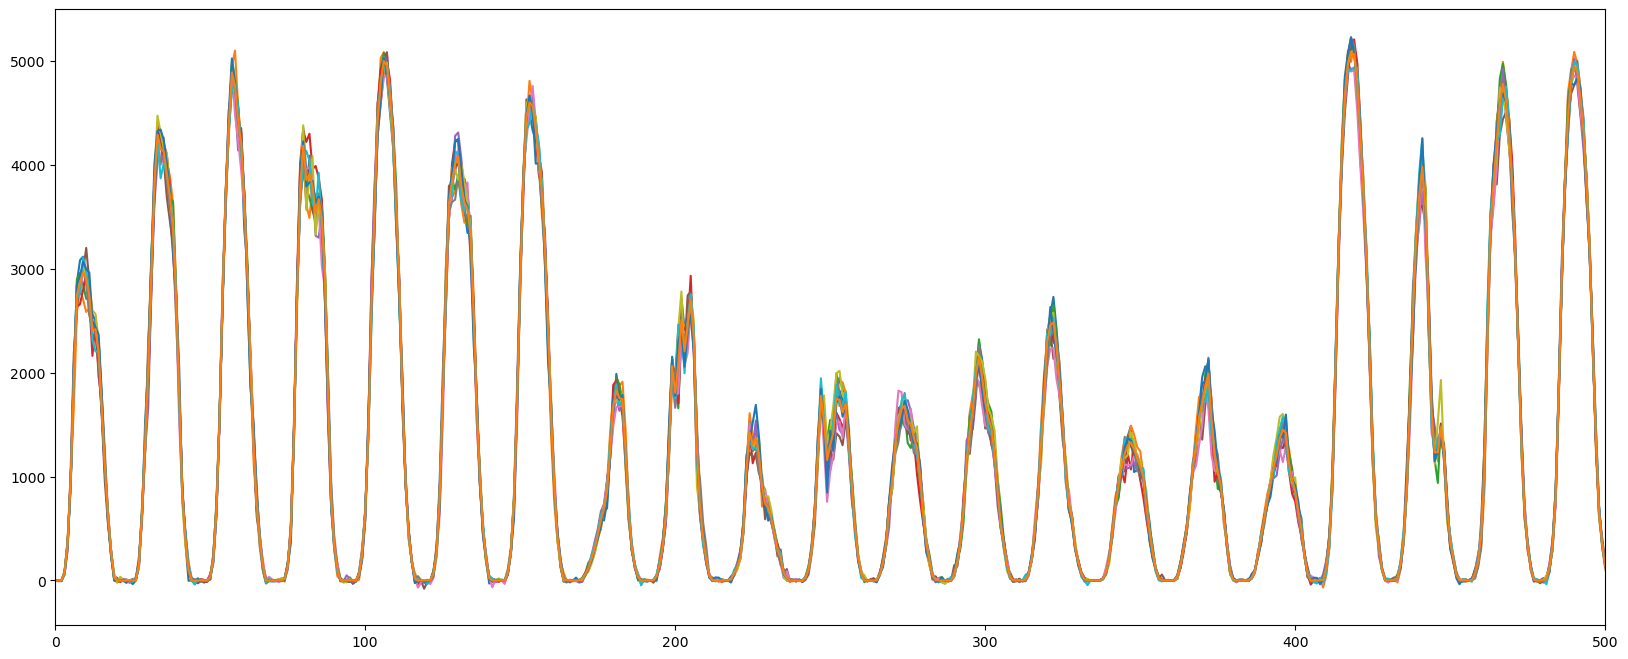

In [30]:
pred_only_pred = predictions.iloc[:,-12:]
plt.figure(figsize=(20,8))
plt.xlim(0,500)
#plt.ylim(-20,100)
plt.plot(pred_only_pred);

In [24]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,NaN,0.000000,NaN,0.000000,NaN,0.489698,0.038500,-0.023706,-0.011820,-1.653340,-0.559751,0.835530,-0.013880,-0.191757,0.006791,0.003773,0.000578
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,NaN,0.000000,0.000000,0.000000,0.000000,-5.579740,-0.454217,0.001711,0.025563,-0.006602,0.228443,-7.676395,-0.007622,0.068488,-0.379527,-0.135776,-0.123534
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.042500,11.475000,0.000000,3143.002441,0.000000,4.673325,-6.618059,0.719303,2.688565,-2.534161,-0.385655,-0.769403,-8.537316,3.208530,-0.353605,4.536057,-4.163466
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,NaN,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000

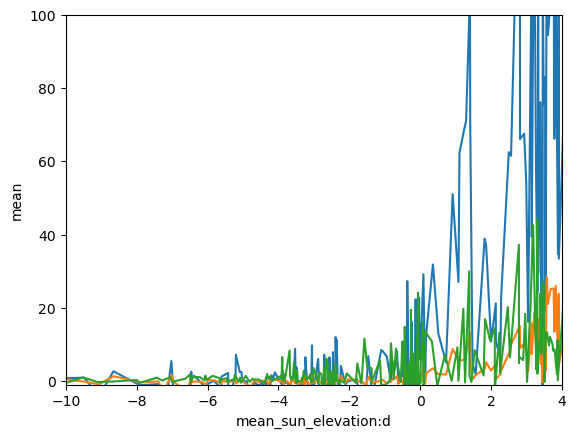

In [25]:
predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

In [26]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [27]:
predictions['mean'].to_csv('catBoost_ensemble_12.csv', index=True)

In [28]:
cat = pd.read_csv('submission_files/151_90043_feature_extraction2_scaled_tuned_depth13.csv')['prediction'].to_list()

predictions.append(cat)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_root = 'https://autogluon.s3.amazonaws.com/datasets/Inc/'
train_data = TabularDataset(data_root + 'train.csv')
test_data = TabularDataset(data_root + 'test.csv')

predictor = TabularPredictor(label='class').fit(train_data=train_data)
predictions = predictor.predict(test_data)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions

In [ ]:


predictions

array_preds = np.array(predictions)
predictions_mean = pd.Series(np.average(array_preds,axis=0))

In [ ]:
predictions_mean.loc[X_sub_agg['min_sun_elevation:d'] < -1] = 0

predictions_mean.to_csv('submission_files/ensemble.csv',index=True)

In [ ]:

m_wrap.y_pred_to_csv(predictions_mean, X_sub_agg, is_aggregated=True,name='ensemble.csv',sun_el_thr=-5)

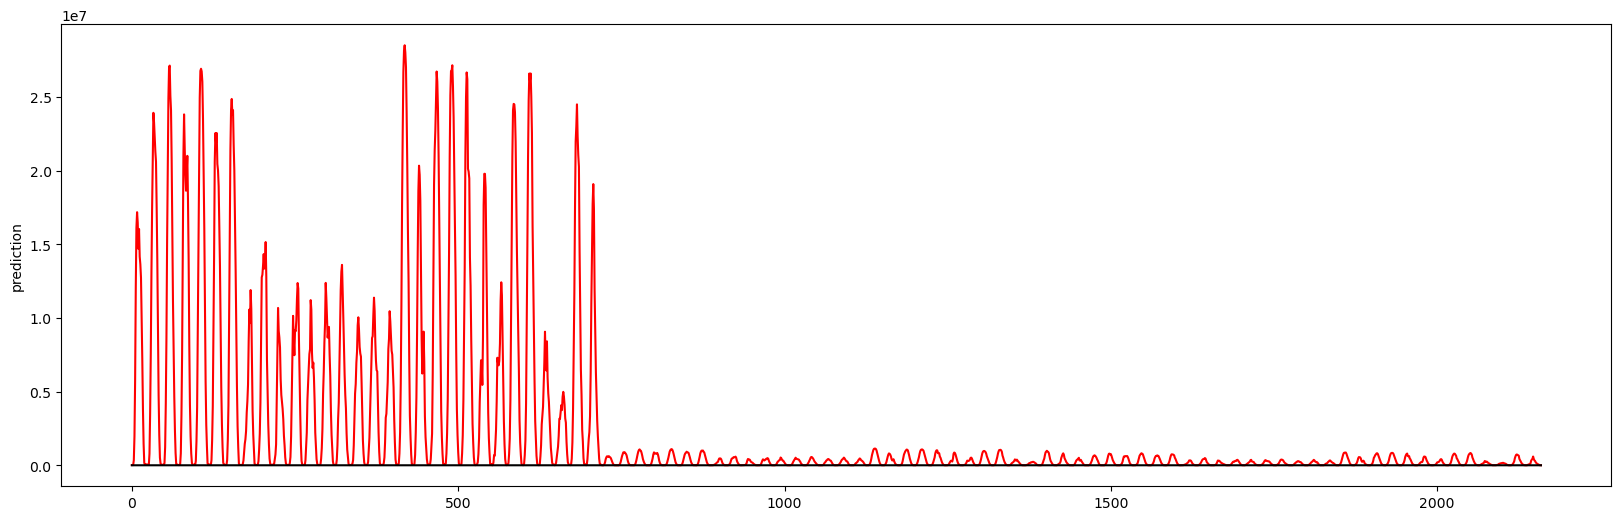

KeyError: 'hourDayMonthYear'

In [ ]:
m_wrap.plot_yPredSub_vs_submission(predictions_mean, X_sub_agg)
m_wrap.y_pred_to_csv(predictions_mean,X_train_agg,True,'building_bagging.csv',1)

In [ ]:
predictions_mean

0    274.467289
dtype: float64